In [28]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
import random

In [29]:
accuracies=[]
data = sio.loadmat('./relative_attributes_v2/relative_attributes/pubfig/data.mat')
attr_names = []
for x in data['attribute_names'][0]:
    attr_names.append(x[0])
data['attribute_names'] = attr_names
data['feat']=np.array(data['feat'])
data['im_names'] = data['im_names'][0]
data['class_labels'] = data['class_labels'][:, 0]
data['used_for_training'] = data['used_for_training'][:, 0]
data['class_names'] = data['class_names'][0]
# data['used_for_feedback']=data['used_for_training']
# for i in range(len(data['feat'])):
#     if(data['used_for_training'][i]!=1 and random.uniform(0, 1)<0.2):
#         data['used_for_feedback'].append(1)
#     else:
#         data['used_for_feedback'].append(0)

In [30]:
w=np.load('./results/WeightMatrix.npy')
data['score']=[]
Noimages=[]
for Class in range(len(data['class_names'])):
    Noimages.append(0)
    data['score'].append([])
    for attr in range(len(data['attribute_names'])):
        data['score'][Class].append([0])
for i in range(len(data['feat'])):
    Noimages[data['class_labels'][i]-1]+=1
    data['score'][data['class_labels'][i]-1]+=np.dot(data['feat'][i],w)
for Class in range(len(data['class_names'])):
    for attr in range(len(data['attribute_names'])):
        data['score'][Class][attr]/=Noimages[Class]

In [31]:
# sum(np.logical_and(data['class_labels']==1 , data['used_for_training']==1))
# sum(data['class_labels']==1)
# Now construct a RBF SVM classifier with data['used for training'] 
data['score'][0]

array([[ 0.08655878],
       [-0.46632226],
       [ 0.04054777],
       [-0.08328188],
       [ 0.32429114],
       [ 0.00530599],
       [-0.07618886],
       [ 0.19067046],
       [ 0.39156408],
       [-0.43971844],
       [-0.36929606]])

In [6]:
from sklearn.svm import SVC

In [7]:
binclassifier=[]
X=[]
Y=[]
trainingset=[]
for Class in range(len(data['class_names'])):
    binclassifier.append(SVC(gamma='auto',kernel='rbf',probability=True))
    X.append([])
    Y.append([])
    for i in range(len(data['feat'])):
        if(data['class_labels'][i]==Class+1  and data['used_for_training'][i]==1):
            trainingset.append(i)
            print("found for class "+str(Class) +" i "+ str(i))
            break
for Class in range(len(data['class_names'])):
    for i in trainingset:
        if(Class+1==data['class_labels'][i]):
            X[Class].append(data['feat'][i])
            Y[Class].append(1)
        else:
            X[Class].append(data['feat'][i])
            Y[Class].append(-1)
        data['used_for_training'][i]=0
    binclassifier[Class].fit(X[Class],Y[Class])

found for class 0 i 0
found for class 1 i 103
found for class 2 i 195
found for class 3 i 291
found for class 4 i 383
found for class 5 i 482
found for class 6 i 577
found for class 7 i 678


In [8]:
data['used_for_feedback']=[]
for i in range(len(data['feat'])):
    if(data['used_for_training'][i]!=1 and random.uniform(0, 1)<0.25):
        data['used_for_feedback'].append(1)
    else:
        data['used_for_feedback'].append(0)
data['used_for_feedback']+=data['used_for_training']

In [ ]:
data['used_for_training']

In [11]:
predictedclass=classifyAccuracy()

accuracy is : 8.419689119170984


In [10]:
def classifyAccuracy():
    count=0
    count1=0
    predictedClass=[]
    for i in range(len(data['feat'])):
        predictedClass.append(-1)
        maxProb=0
        den=0
    #     for j in range(len(data['class_names'])):
    #         den+=binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]
        for j in range(len(data['class_names'])):
            if(maxProb<binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]):
                maxProb=binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]
                predictedClass[len(predictedClass)-1]=j
    #         print(binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1])
    #     print(predictedClass,data['class_labels'][i]-1)
        if(predictedClass[len(predictedClass)-1]==data['class_labels'][i]-1):
            count+=1
    # print()
    #     print(classifier.predict_proba([data['feat'][i]]),data['class_labels'][i])
    # print(trainingCount,count1,count/len(data['feat']))
#     print("accuracy is :",100*count/len(data['feat']))
    accuracies.append(100*count/len(data['feat']))
    return predictedClass

In [12]:
# data['used_for_feedback']=data['used_for_training']
countT=0
countF=0
for i in range(len(data['feat'])):
    if(data['used_for_feedback'][i]==1):
        countF+=1
    if(data['used_for_training'][i]==1):
        countT+=1
print(countT,countF,len(data['feat']))

233 363 772


In [13]:
# # Now query the image with maximum entropy min(classifier.predict_proba(data['feat'][i])[0])
# xStar=int(np.argmax(classifier.predict_proba(data['feat']))/8)
# plt.imshow(cv2.imread('./relative_attributes_v2/relative_attributes/osr/spatial_envelope_256x256_static_8outdoorcategories/'+data['im_names'][xStar][0]))
# data['class_names'][data['class_labels'][xStar]-1][0],data['class_names'][classifier.predict(data['feat'][xStar].reshape(1,-1))[0]-1][0], data['attribute_names'], data['class_names']
def xstar():
    maxEntropy=0
    maxIndex=-1
    for i in range(len(data['feat'])):
        if(data['used_for_feedback'][i]==1):
            den=0
            for j in range(len(data['class_names'])):
                den+=binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]
            for j in range(len(data['class_names'])):
                prob=binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]
                if(maxEntropy<prob/den):
                    maxEntropy=prob/den
                    maxIndex=i
    if(maxIndex!=-1):
        predictedclass=classifyAccuracy()
        if(data['class_labels'][maxIndex]-1 == predictedclass[maxIndex]):
            correctPred(maxIndex)
            maxIndex=xstar()
        else:
    #         plt.imshow(cv2.imread('./relative_attributes_v2/relative_attributes/pubfig/images/' + data['im_names'][maxIndex][0]))
    #         plt.title("Actual:"+ data['class_names'][data['class_labels'][maxIndex]-1][0]+ "\n"+ "Predicted:"+ data['class_names'][predictedclass[maxIndex]][0])
            diff=data['score'][predictedclass[maxIndex]]-np.dot(data['feat'][maxIndex],w)
            maxV=0
            for ite in range(len(diff)):
                temp=abs(diff[ite])
                if(maxV<temp):
                    maxV=temp
                    maxi=ite
            if(diff[maxi]<0):
    #           then it will be less than required
                wrongPred(ite,-1,maxIndex,predictedclass)
                xstar()
            else:
    #             then it is more than required
                wrongPred(ite,1,maxIndex,predictedclass)
                xstar()
    return maxIndex

In [16]:
maxindex=xstar()
print(maxindex)

accuracy is : 8.419689119170984
accuracy is : 15.025906735751295
accuracy is : 11.917098445595855
accuracy is : 11.010362694300518
accuracy is : 13.601036269430052
accuracy is : 12.435233160621761
accuracy is : 13.73056994818653
accuracy is : 16.580310880829014
accuracy is : 14.119170984455959
accuracy is : 13.082901554404145
accuracy is : 13.73056994818653
accuracy is : 13.73056994818653
accuracy is : 16.191709844559586
accuracy is : 15.932642487046632
accuracy is : 17.746113989637305
accuracy is : 15.67357512953368
accuracy is : 15.155440414507773
accuracy is : 15.284974093264248
accuracy is : 18.65284974093264
accuracy is : 15.025906735751295
accuracy is : 13.212435233160623
accuracy is : 20.207253886010363
accuracy is : 19.559585492227978
accuracy is : 17.098445595854923
accuracy is : 20.077720207253886
accuracy is : 20.72538860103627
accuracy is : 18.134715025906736
accuracy is : 23.963730569948186
accuracy is : 25.129533678756477
accuracy is : 20.984455958549223
accuracy is : 24.

accuracy is : 32.90155440414508
accuracy is : 28.497409326424872
accuracy is : 33.29015544041451
accuracy is : 33.80829015544042
accuracy is : 33.031088082901555
accuracy is : 33.29015544041451
accuracy is : 34.97409326424871
accuracy is : 34.32642487046632
accuracy is : 35.233160621761655
accuracy is : 29.27461139896373
accuracy is : 29.533678756476682
accuracy is : 28.10880829015544
accuracy is : 32.64248704663213
accuracy is : 35.233160621761655
accuracy is : 34.067357512953365
accuracy is : 35.62176165803109
accuracy is : 34.715025906735754
accuracy is : 37.17616580310881
accuracy is : 33.67875647668394
accuracy is : 32.90155440414508
accuracy is : 32.12435233160622
accuracy is : 31.088082901554404
accuracy is : 30.958549222797927
accuracy is : 30.958549222797927
accuracy is : 31.60621761658031
accuracy is : 30.958549222797927
accuracy is : 34.4559585492228
accuracy is : 32.12435233160622
accuracy is : 32.25388601036269
accuracy is : 31.865284974093264
accuracy is : 33.678756476683

In [14]:
def wrongPred(attribute,flag,maxIndex,predictedClass):
# More male to be scarlett Johnson
# So iterate through all the feedback images and if any photo is more male than this then it wont be scarlett
    w=np.load('./results/WeightMatrix.npy')
    predc=predictedClass[maxIndex]
    actualc=data['class_labels'][maxIndex]-1
    X[actualc].append(data['feat'][maxIndex])
    Y[actualc].append(1)
    attributeScore=np.dot(data['feat'][maxIndex],w[attribute])
    if(flag==-1):
        for i in range(len(data['feat'])):
            if(data['used_for_feedback'][i]==1):
                if(np.dot(data['feat'][i],w[attribute])<=attributeScore):
                    X[predc].append(data['feat'][i])
                    Y[predc].append(-1)
    else:
        for i in range(len(data['feat'])):
            if(data['used_for_feedback'][i]==1):
                if(np.dot(data['feat'][i],w[attribute])>=attributeScore):
                    X[predc].append(data['feat'][i])
                    Y[predc].append(-1)
    data['used_for_feedback'][maxIndex]=0
    binclassifier[actualc]=SVC(gamma='auto',kernel='rbf',probability=True)
    binclassifier[predc]=SVC(gamma='auto',kernel='rbf',probability=True)
    binclassifier[actualc].fit(X[actualc],Y[actualc])
    binclassifier[predc].fit(X[predc],Y[predc])

In [15]:
def correctPred(maxIndex):
    data['used_for_feedback'][maxIndex]=0
    for j in range(len(data['class_names'])):
        if(j==data['class_labels'][maxIndex]-1):
            X[j].append(data['feat'][maxIndex])
            Y[j].append(1)
        else:
            X[j].append(data['feat'][maxIndex])
            Y[j].append(-1)
        binclassifier[j]=SVC(gamma='auto',kernel='rbf',probability=True)
        binclassifier[j].fit(X[j],Y[j])

In [27]:
finalAcc=accuracies
import pickle
with open("accuraciesScratch.txt", "wb") as fp:
    pickle.dump(finalAcc, fp)

Text(0.5,0,'No. of Feedback Images')

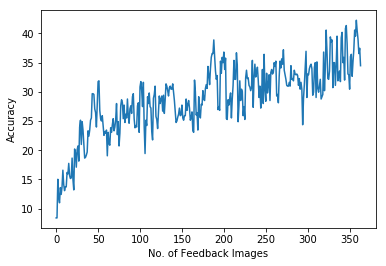

In [26]:
accuracies=np.array(accuracies)
import matplotlib.pyplot as plt
import cv2
plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('No. of Feedback Images')

In [ ]:
# data['class_names']
import matplotlib.pyplot as plt
import cv2
plt.imshow(cv2.imread('./relative_attributes_v2/relative_attributes/pubfig/images/'+data['im_names'][maxi][0]))
if(classifier.predict(data['feat'][maxi])!=1):
    plt.title("Actual:"+ data['im_names'][maxi][0].split('_')[0]+ "\n"+ "Wrongly Predicted")
data['attribute_names']

In [ ]:
countfeedback=0
counttraining=0
countrem=0
for i in range(len(data['feat'])):
    if(data['used_for_feedback'][i]==1):
        countfeedback+=1
    elif(data['used_for_training'][i]==1):
        counttraining+=1
    else:
        countrem+=1
countfeedback,counttraining,countrem

In [ ]:
count=[0,0,0,0,0,0,0,0]
for i in range(len(data['feat'])):
    if(data['used_for_training'][i]==1):
        count[data['class_labels'][i]-1]+=1
count

In [ ]:
a=[1,2]
c=[2,3]
b= [a,c]
np.argmax(b)